<a href="https://colab.research.google.com/github/debjanim/streamflow-prediction/blob/main/test_streamflow_xgboost_214.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### The YouTube XGBoost Model
##### Following the wonderful tutorial. 

### A sMAPE score of 40.332794203223905 %

YT link: https://www.youtube.com/watch?v=vV12dGe_Fho


### Phase 1) Preparing the data. 
##### Isolating the watershed with the fewest missing discharge values, and interpolating those missing values.

In [ ]:
# Import relevant libraries. 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
import seaborn as sns
import xgboost as xgb 
from sklearn.metrics import mean_squared_error

In [ ]:
# Load Data from Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Copy the relevant .csv file to local drive. 
!cp /content/drive/MyDrive/EDAs/HYSETS_important.csv /content/

In [ ]:
# Load the dataframe
# Note!!! I've previously removed all columns but time, watershed, pr, tasmax, tasmin, and discharge.
df = pd.read_csv('HYSETS_important.csv')
df.head()

,time,watershed,pr,tasmax,tasmin,discharge
0,1950-01-01,0,6.4,-27.2,-38.9,NaN
1,1950-01-02,0,1.3,-27.8,-39.4,NaN
2,1950-01-03,0,0.0,-15.6,-41.1,NaN
3,1950-01-04,0,0.0,-15.0,-21.7,NaN
4,1950-01-05,0,0.0,-12.2,-26.1,NaN


##### Choosing a watershed. 
##### If a model that takes in the 290 sheds proves too difficult, it has been suggested that focusing on one watershed could provide an easier start to get the ball rolling. 

In [ ]:
# 1) Create a dictionary to store key-value pairs.
missing = {}
# 2) Create the variable that represents each unique watershed
uni = df.watershed.unique()
#3) Create a loop that will iterate over watersheds, assigning missing discharge sums to a watershed, and stores both in a dictionary. 
for i in uni: 
  shed = df[(df.watershed == i)]
  nums = shed.discharge.isnull().sum()
  missing[nums] = i
# What is the most populous discharge value'd watershed?
sorted(missing.items())[0:10] 

[(551, 175),
 (1096, 8),
 (1741, 205),
 (4362, 159),
 (4442, 252),
 (4908, 110),
 (5195, 214),
 (5665, 27),
 (5987, 147),
 (6149, 236)]

In [ ]:
# This model will focus on watershed 214 
shed214 = df[(df.watershed == 214)]
# Switching the 'time' column to the datetime format.
shed214["time"] = pd.to_datetime(shed214["time"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
# For ease of experimentation between watersheds, a copy will be made. 
copy = shed214.copy()

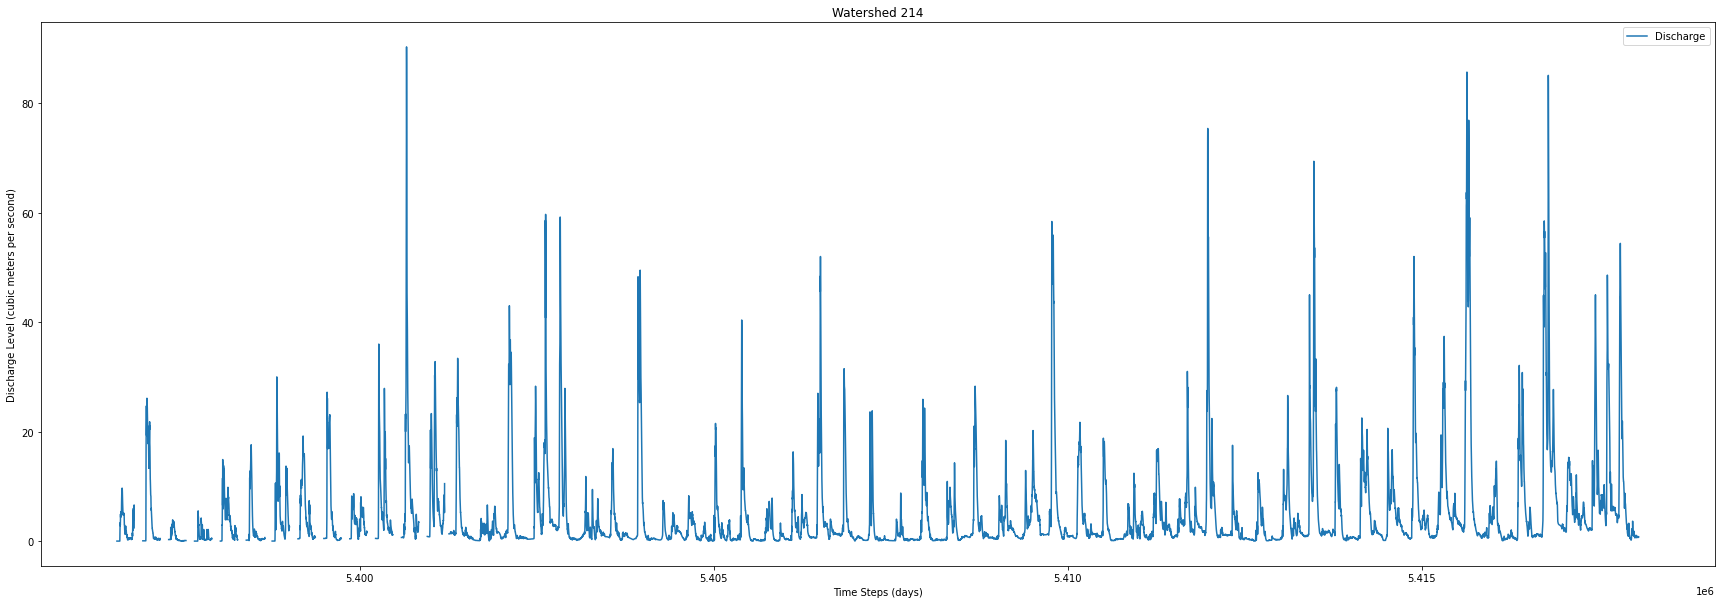

In [ ]:
# For visual representation, plotting discharge of watershed 214

x = range(len(copy))
y1 = copy.discharge

f = plt.figure()
f.set_figwidth(30)
f.set_figheight(10)
plt.title("Watershed 214")
plt.xlabel("Time Steps (days)") # A track varies in timing, but averages to every 3 days.
plt.ylabel("Discharge Level (cubic meters per second)")
plt.plot(y1, label = 'Discharge')


plt.legend()
plt.show()

##### This is what I bin as an 'A' class watershed, as it has most of its recent discharge values, and these values are dubious zeroes. 

In [ ]:
# Though the dataframe's final row is Dec.31 2018, many of the watersheds stopped recording before this. 
# Observe final recording date. 
copy.dropna()

,time,watershed,pr,tasmax,tasmin,discharge
5396574,1959-03-01,214,0.000000,4.022471,-6.081390,0.00
5396575,1959-03-02,214,0.000000,-0.101158,-4.413668,0.00
5396576,1959-03-03,214,0.000000,-6.066950,-16.086332,0.00
5396577,1959-03-04,214,0.840077,-1.090502,-16.328495,0.00
5396578,1959-03-05,214,0.321853,-2.495444,-5.582239,0.00
...,...,...,...,...,...,...
5418060,2017-12-27,214,0.957529,-22.027567,-37.354053,0.72
5418061,2017-12-28,214,0.710270,-20.577143,-31.949420,0.73
5418062,2017-12-29,214,0.782085,-26.578997,-36.151043,0.74
5418063,2017-12-30,214,0.732355,-26.989113,-39.858610,0.74


In [ ]:
# As the final recording is not 2018-12-31, these extra rows will be dropped. In addition, for this model we will only focus on the last five years. 
copy = copy[(copy.time >= '2013-01-01') & (copy.time < '2018-01-01')]

In [ ]:
# Using Pandas built in function 'interpolate', NaN values will be filled in. Most of the obvservable NaN values are in the earlier years. 
copy.set_index('time', inplace = True)
for watershedID in set(copy["watershed"]):
  copy[copy["watershed"] == watershedID] = copy[copy["watershed"] == watershedID].interpolate(method='time', axis=0, limit_direction="both")

In [ ]:
# Observe how many nan's remain after interpolation. 
copy.isnull().sum()

watershed    0
pr           0
tasmax       0
tasmin       0
discharge    0
dtype: int64

### Phase Two: Feature Selection

In [ ]:
# Cumulative rainfall from the past ten days could be useful information for the model. 
# Create a list to store 10-day rainfall values
rainfall = []
# Create a loop to iterate though dataframe. 
for i in range(len(copy.pr)): 
  # Start at the tenth value. 
  if i < 10:
    rain = copy.pr[:i].sum()
  elif i >= 10:
    rain = copy.pr[i-10:i].sum()
  rainfall.append(rain)
print("Length:", len(rainfall), "First ten values:", rainfall[0:10])

Length: 1826 First ten values: [0.0, 1.5805405, 1.99745168, 2.16888026, 2.16888026, 2.3062547799999997, 2.3062547799999997, 2.97652504, 5.62795354, 5.742239255]


In [ ]:
copy['10_day_rain'] = rainfall

In [ ]:
# The model might gain unseful incites from what day of the year, what week, what month and what quarter. 
def create_features(copy):
  copy['day'] = copy.index.dayofyear
  copy['week'] = copy.index.weekofyear
  copy['month'] = copy.index.month
  copy['quarter'] = copy.index.quarter
  return copy

In [ ]:
copy = create_features(copy)
copy.head(3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  after removing the cwd from sys.path.


,watershed,pr,tasmax,tasmin,discharge,10_day_rain,day,week,month,quarter
time,,,,,,,,,,
2013-01-01,214,1.580540,-4.430734,-27.376835,0.50,0.000000,1,1,1,1
2013-01-02,214,0.416911,-6.926100,-16.462856,0.50,1.580540,2,1,1,1
2013-01-03,214,0.171429,-2.524942,-16.796988,0.48,1.997452,3,1,1,1


In [ ]:
# For this model, three columns will be dropped. 
copy = copy.drop(['watershed', 'tasmax', 'tasmin'], axis=1)

### Phase 3) Machine Learning. Herein will be used XGboost. 
##### For the regressor prediction will operate in an iterative process. 


In [ ]:
# Instantiate the model.
reg = xgb.XGBRegressor(n_estimators=500, learning_rate=0.01)

In [ ]:
# Create the predictor and target variables. 
num = 31
predict = copy.iloc[num-31:num-1] # As we will be predicting the final year, this does not need to be modified to num+1
target = copy.discharge.iloc[num-30:num]
print("The first predictors will be:\n", predict.iloc[0],"\n \nAnd the first target will be:", target.iloc[0])

The first predictors will be:
 pr             1.58054
discharge      0.50000
10_day_rain    0.00000
day            1.00000
week           1.00000
month          1.00000
quarter        1.00000
Name: 2013-01-01 00:00:00, dtype: float64 
 
And the first target will be: 0.5


In [ ]:
# Create the loop that will predict the next day's discharge. 
pred_list = [] # Create a list to store the predictions. 
for i in range(len(copy)):
  num = i
  if i >= round(len(copy)*0.60): # Only the last year will be predicted iteratively, so the loop begins after 4 years. 
    num = i # Change the value of num.
    print(i)
    predict = copy.iloc[num-366:num-1] # As we will be predicting the final year, this does not need to be modified to num+1
    target = copy.discharge.iloc[num-365:num]
    reg.fit(predict, target) # Fit the data into the XGboost model. 
    predictions = reg.predict(predict)
    day = predictions[364]
    pred_list.append(day) # Append the predictions to the list, for graphing. 

1096
[16:33:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
1097
[16:33:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
1098
[16:33:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
1099
[16:33:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
1100
[16:33:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
1101
[16:33:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
1102
[16:33:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
1103
[16:33:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg

In [ ]:
# Observe if the correct number of values are stored, and what they are. 
print(len(pred_list), pred_list[0:10])

730 [2.363759, 2.327221, 2.3280103, 2.2686746, 2.2720919, 2.2661934, 2.2612264, 2.2586775, 2.254084, 2.2517984]


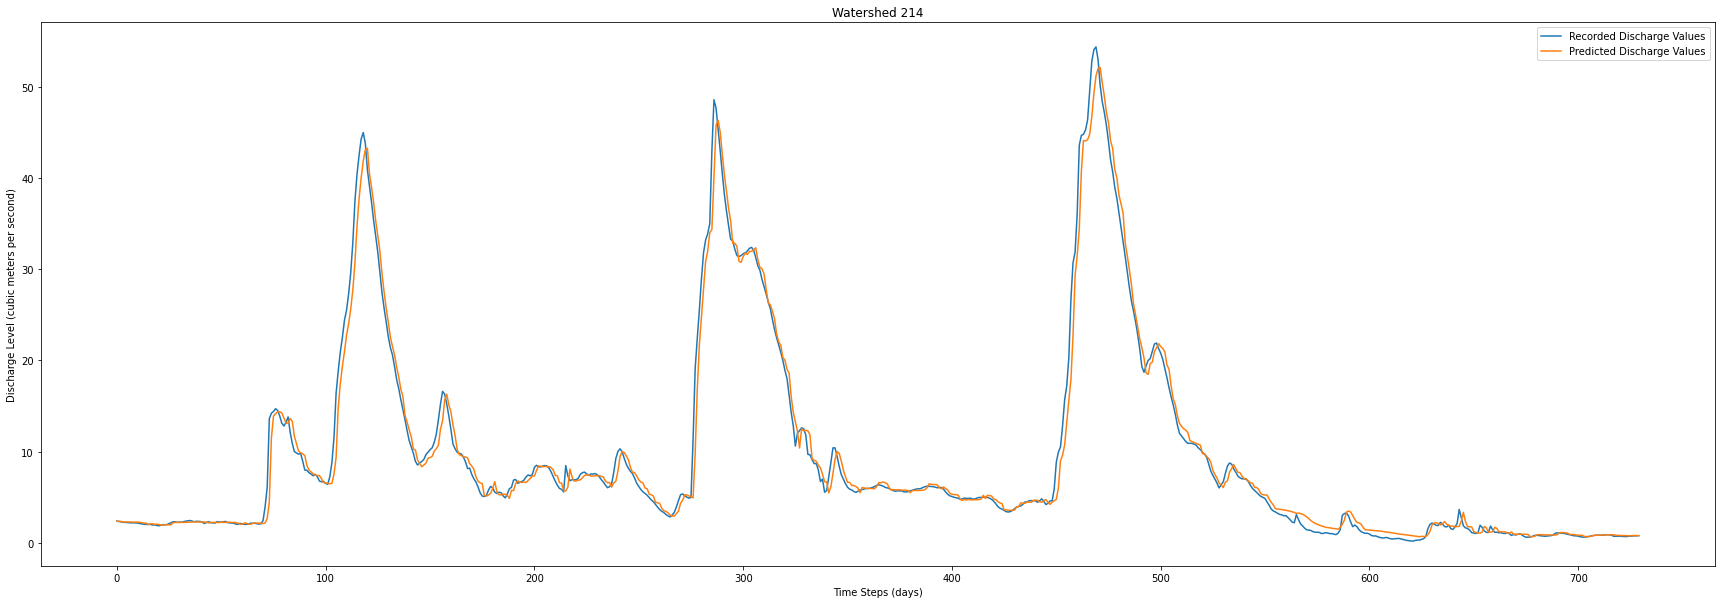

In [ ]:
# For visual representation, plotting discharge of watershed 175
# Note! Watershed 175 is an excellent introductory watershed, as the discharge spikes follow a relatively gentler roll. 
x = range(len(pred_list))
y1 = copy.discharge.values[round(len(copy)*0.6):]
y2 = pred_list

f = plt.figure()
f.set_figwidth(30)
f.set_figheight(10)
plt.title("Watershed 214")
plt.xlabel("Time Steps (days)") # A track varies in timing, but averages to every 3 days.
plt.ylabel("Discharge Level (cubic meters per second)")
plt.plot(y1, label = 'Recorded Discharge Values')
plt.plot(y2, label = 'Predicted Discharge Values')




plt.legend()
plt.show()

In [ ]:
# Create a loop that will go through the predictions and actuals. 
smape = 0
for i in range(len(pred_list)):
  top = y2[i] - y1[i]
  top = np.abs(top)
  bottom = np.abs(y2[i]) + np.abs(y1[i])
  bottom = bottom/2
  answer = top/bottom
  answer = answer*100
  smape += answer
total = smape/len(pred_list)

print("The SMAPE score is:", total)

The SMAPE score is: 13.64977526264813


In [ ]:
"""# Finally, to plot the predicted discharge values against the recorded. 
prediction = reg.predict(x_test)"""


'# Finally, to plot the predicted discharge values against the recorded. \nprediction = reg.predict(x_test)'

In [ ]:
"""reg.fit(x_train, y_train,
        eval_set = [(x_train, y_train), (x_test, y_test)],
        early_stopping_rounds = 50, 
        verbose=100)"""

[19:48:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:141.706	validation_1-rmse:188.142
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[100]	validation_0-rmse:85.6861	validation_1-rmse:118.224
[200]	validation_0-rmse:74.2733	validation_1-rmse:94.6416
[300]	validation_0-rmse:71.8826	validation_1-rmse:86.8162
[400]	validation_0-rmse:70.9498	validation_1-rmse:84.2329
[500]	validation_0-rmse:70.4199	validation_1-rmse:83.3585
[600]	validation_0-rmse:69.9656	validation_1-rmse:83.0884
[700]	validation_0-rmse:69.5856	validation_1-rmse:83.035
[800]	validation_0-rmse:69.2364	validation_1-rmse:83.0022
Stopping. Best iteration:
[806]	validation_0-rmse:69.2136	validation_1-rmse:82.996



XGBRegressor(learning_rate=0.01, n_estimators=1000)

In [ ]:
1==1

True

In [ ]:
"""# The test data will be five years of data (2014 - 2018). 
# This step is put later, so the df_train and df_test do not need to be put through the create_features function. 

df_train = df[(df.index < '2014-01-01')]
df_test = df[(df.index >= '2014-01-01')]
print("Test set fraction:", len(df_test) / len(df))"""

'# The test data will be five years of data (2014 - 2018). \n# This step is put later, so the df_train and df_test do not need to be put through the create_features function. \n\ndf_train = df[(df.index < \'2014-01-01\')]\ndf_test = df[(df.index >= \'2014-01-01\')]\nprint("Test set fraction:", len(df_test) / len(df))'

In [ ]:
"""# Create the training and test features and target datasets. 
# Note, I do this by a different means in the video. There are many methods for doing so, and the method in the video is fine as well. 
x_train = df_train.drop(['discharge'], axis=1)
x_test = df_test.drop(['discharge'], axis=1)
y_train = df_train.discharge
y_test = df_test.discharge"""

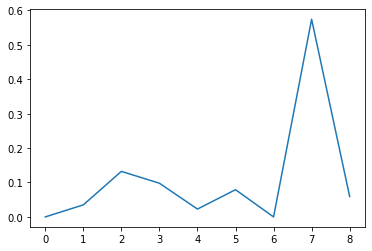

In [ ]:
"""# Plot the feature importances, for a visual on what the model is relying on to make predictions. 
regu = reg.feature_importances_
x = range(len(regu))
y = regu
plt.plot(x,y)"""

In [ ]:
plot_test = x_test.copy()
plot_test.reset_index(inplace=True)

In [ ]:
plot_test['discharge'] = y_test


In [ ]:
for i in range(len(plot_test)):
  plot_test.discharge[i] = y_test[i]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### SMAPE scoring. 
##### score = absolute(prediction - actual) / ((absolute(prediction)  + absolute(actual))/2)

In [ ]:
# Herein we will create a function that creates represenations of the past days. 
# And A fortnight is the target variable. --> This can be changed to 10 days out, instead of 14. 

def advance(x):
  num_list = []
  length = len(model1.discharge)
  for i in range(length):
    if x + i >= length: # For calculating the target variable
      num = i
    elif i + x < 0: # For calculating the past. 
      num = i
    else:
      num = i + x # Other than the outliers, the value will be discharge[i + 'x']
    forecast = model1['discharge'][num]
    num_list.append(forecast)
  name = f"discharge_{x}"    
  model1[name] = num_list #model1['discharge'][num]


In [ ]:
# Yesterday's forecast. 
advance(-1)

In [ ]:
# Three days ago.
advance(-3)

In [ ]:
# Five days ago.
advance(-5)

In [ ]:
# One week ago.
advance(-7)

In [ ]:
# The target variable, two weeks out.
advance(14)

In [ ]:
model1.tail(20)

,time,watershed,pr,tasmax,tasmin,discharge,discharge_-1,discharge_-3,discharge_-5,discharge_-7,discharge_14
24452,2016-12-12,205,0.000000,-18.164406,-27.025156,3.82,3.94,4.18,4.40,4.76,2.48
24453,2016-12-13,205,0.000000,-16.172234,-24.161900,3.71,3.82,4.06,4.31,4.31,2.64
24454,2016-12-14,205,0.000000,-20.890396,-26.313570,3.60,3.71,3.94,4.18,4.40,2.65
24455,2016-12-15,205,0.000000,-15.734134,-26.880585,3.50,3.60,3.82,4.06,4.31,2.61
24456,2016-12-16,205,0.000000,-22.829750,-28.378078,3.39,3.50,3.71,3.94,4.18,2.52
24457,2016-12-17,205,0.000000,-24.311274,-32.428288,3.29,3.39,3.60,3.82,4.06,2.57
24458,2016-12-18,205,1.188727,-11.516911,-32.155636,3.20,3.29,3.50,3.71,3.94,3.20
24459,2016-12-19,205,1.088935,-1.979227,-13.009812,3.10,3.20,3.39,3.60,3.82,3.10
24460,2016-12-20,205,0.073486,-0.972338,-14.880480,3.01,3.10,3.29,3.50,3.71,3.01
24461,2016-12-21,205,0.000000,-0.989353,-17.502089,2.92,3.01,3.20,3.39,3.60,2.92


In [ ]:
# We will only be using discharge values. --> Pr values, at the minimum, also need to be considered.
model1.drop(['watershed', 'pr', 'tasmax', 'tasmin'], axis=1, inplace=True)

model1.head(3)

,time,discharge,discharge_-1,discharge_-3,discharge_-5,discharge_-7,discharge_14
0,1950-01-01,6.85,6.85,6.85,6.85,6.85,6.85
1,1950-01-02,6.85,6.85,6.85,6.85,6.85,6.85
2,1950-01-03,6.85,6.85,6.85,6.85,6.85,6.85


In [ ]:
# We will be focusing on the last twenty years of data.
df = model1[(model1.time >= '1997-01-01')] 

df.head(3)

,time,discharge,discharge_-1,discharge_-3,discharge_-5,discharge_-7,discharge_14
17167,1997-01-01,1.32,1.48,1.66,1.28,1.44,1.32
17168,1997-01-02,1.39,1.32,1.29,1.52,1.38,1.16
17169,1997-01-03,1.46,1.39,1.48,1.66,1.28,1.12


In [ ]:
# The test data will be five years of data (2012 - 2017). 

df_train = df[(df.time < '2012-01-01')]
df_test = df[(df.time >= '2012-01-01')]
print("Test set fraction:", len(df_test) / len(df))

Test set fraction: 0.2501026694045175


In [ ]:
# The 'time' column won't be needed for the RFR model. 
df_train.drop(['time'], axis=1, inplace=True)
df_test.drop(['time'], axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
df.drop(['time'], axis=1, inplace=True)

### Phase 2) Building the machine learning model.

##### We will be using a random forest regressor for the baseline. 

In [ ]:
# Import relevant libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [ ]:
predict_train = df_train.drop('discharge_14', axis=1)
target_train = df_train['discharge_14']
predict_test = df_test.drop('discharge_14', axis=1)
target_test = df_test['discharge_14']
#x_train, x_test, y_train, y_test = train_test_split(predict, target, test_size=0.2, random_state=42)

In [ ]:
clf = RandomForestRegressor(n_estimators=800) # --> 800 is chosen at random. A Grid Search CV should be done to find best hyperparameters. 
clf.fit(predict_train, target_train)


RandomForestRegressor(n_estimators=800)

In [ ]:
# Testing the model's predictive capabilities. 
clf.score(predict_test,target_test)

0.272040202845357

In [ ]:
# Now to take that wonderfully accurate model and use it to predict the errors of our dataframe. 
aim = predict_test
prediction = clf.predict(aim)
print(prediction)

[0.941675  0.8235739 2.5969875 ... 2.3411875 2.687475  2.5546   ]


In [ ]:
bullseye = target_test
bullseye.reset_index(drop=True, inplace=True)

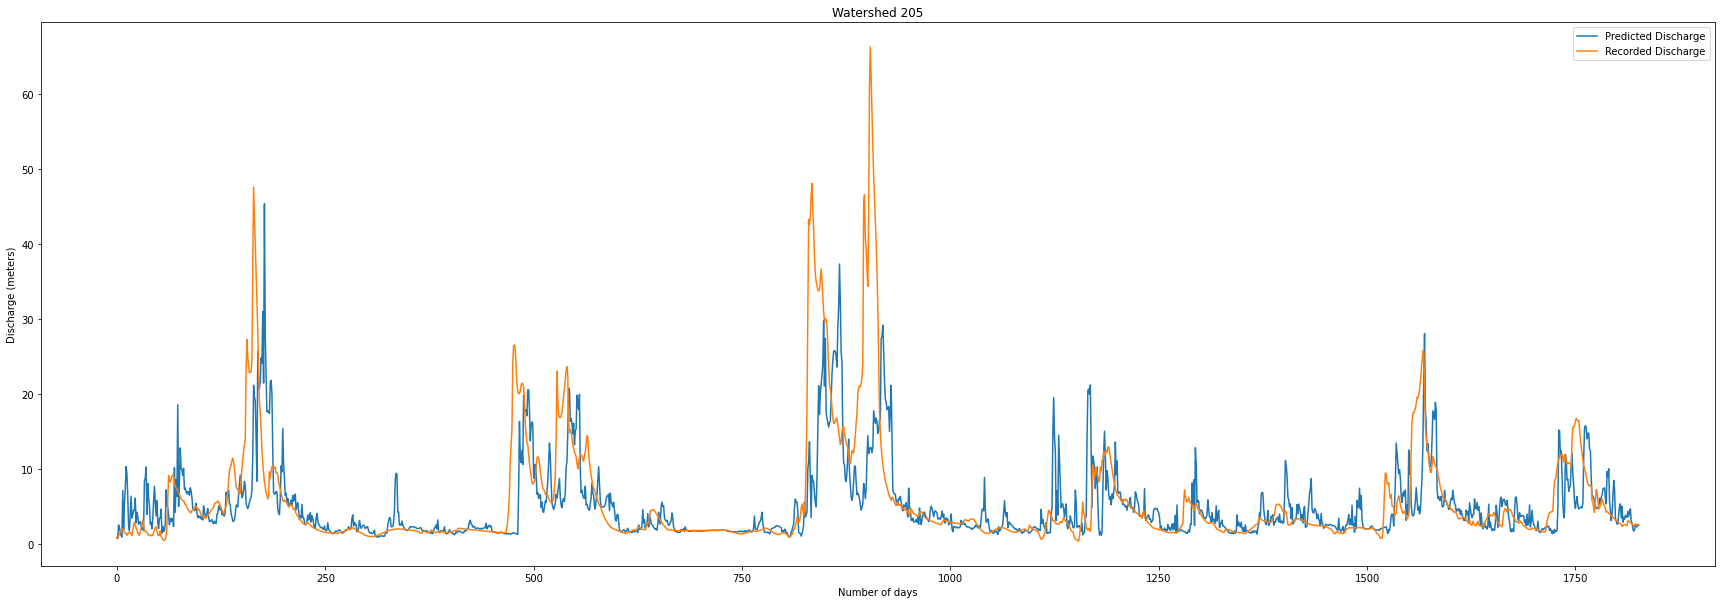

In [ ]:
# Plot the errors and water levels next to each oter to observe potential patterns. 
f = plt.figure()
f.set_figwidth(30)
f.set_figheight(10)
plt.title("Watershed 205")
plt.xlabel("Number of days") # A track varies in timing, but averages to every 3 days.
plt.ylabel("Discharge (meters)")
y = prediction
y2 = bullseye
plt.plot(y, label="Predicted Discharge")
plt.plot(y2, label="Recorded Discharge")
plt.legend()
plt.show()

In [ ]:
#SMAPE scoring for five years. 

n = len(prediction) # (1827)
total = 0
for i in range(len(prediction)):
  top = (prediction[i] - bullseye[i])
  bottom = ((prediction[i] + bullseye[i]) /2)
  answer = top/bottom
  if answer < 0:
    answer = answer * -1
  total += answer
SMAPE = total/n
SMAPE


0.4050537161232583